In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsepythonserver import *
from tqdm import tqdm
import math
import datetime
import py_vollib.black_scholes_merton.implied_volatility as ivcalc

# Custom imports, from file
from importantFormulae import BlackScholes, getIV

In [45]:
options_data_original = pd.read_csv('./OptionsDataEOD_v2.csv')

In [46]:
# This piece of code will fetch the last 13 years of NIFTY 50 data
# It uses index_history() method from nsepythonserver
# We need to setup proxy server for nsepythonserver to be able to call NSE
# Right now, the below code is dummy and not in use. 

nifty = index_history('NIFTY 50','2010-01-01', end_date='2023-11-16')
nifty = nifty[::-1].set_index(pd.to_datetime(nifty[::-1]['HistoricalDate']))
nifty = nifty.astype({k:'float' for k in nifty.columns[-4:]})

KeyError: 'd'

In [ ]:
# In the below cell, we are formatting the data for our use case. 
# 1. We are dropping first 4 columns, as that is not useful
# The entire data is for NIFTY Options only, and hence we will limit our analysis to that. 
print(options_data_original.columns)

# Number of rows before deletion
print(len(options_data_original))

Index(['Unnamed: 0', '_id', 'FH_INSTRUMENT', 'FH_SYMBOL', 'FH_EXPIRY_DT',
       'FH_STRIKE_PRICE', 'FH_OPTION_TYPE', 'FH_MARKET_TYPE',
       'FH_OPENING_PRICE', 'FH_TRADE_HIGH_PRICE', 'FH_TRADE_LOW_PRICE',
       'FH_CLOSING_PRICE', 'FH_LAST_TRADED_PRICE', 'FH_PREV_CLS',
       'FH_SETTLE_PRICE', 'FH_TOT_TRADED_QTY', 'FH_TOT_TRADED_VAL',
       'FH_OPEN_INT', 'FH_CHANGE_IN_OI', 'FH_MARKET_LOT', 'FH_TIMESTAMP',
       'FH_UNDERLYING_VALUE', 'TIMESTAMP'],
      dtype='object')
985758


In [48]:
# 2. ~options_data.iloc[:,4:].duplicated() - with this code, we are essentially removing duplicates from the table
options_data = options_data_original.iloc[:,4:][~options_data_original.iloc[:,4:].duplicated()].reset_index(drop=True)

# Number of rows after deletion
print(len(options_data))

# Rough Delta = 27,331, what is the reason for this?

# We are converting columns like Expiry date and timestamp to Datetime format
options_data['FH_EXPIRY_DT'] = pd.to_datetime(options_data['FH_EXPIRY_DT'])
options_data['FH_TIMESTAMP'] = pd.to_datetime(options_data['FH_TIMESTAMP'])

# We are dropping some unneeded columns
options_data.drop('TIMESTAMP',axis=1,inplace=True)
options_data.drop('FH_MARKET_TYPE',axis=1,inplace=True)

print(options_data.columns)

options_data = options_data.set_index(['FH_EXPIRY_DT','FH_STRIKE_PRICE','FH_OPTION_TYPE','FH_TIMESTAMP'])
# FH_EXPIRY_DT - Expiry Date of the options contract
# FH_STRIKE_PRICE - Strike Price of the options contract
# FH_OPTION_TYPE - Call Option CE or Put Option PE
# FH_TIMESTAMP - The date for OHLCV OI data. Basically, the row is EOD data, the date is FH_TIMESTAMP

options_data.to_csv('options_data_cleaned.csv', index=False)  

958427
Index(['FH_EXPIRY_DT', 'FH_STRIKE_PRICE', 'FH_OPTION_TYPE', 'FH_OPENING_PRICE',
       'FH_TRADE_HIGH_PRICE', 'FH_TRADE_LOW_PRICE', 'FH_CLOSING_PRICE',
       'FH_LAST_TRADED_PRICE', 'FH_PREV_CLS', 'FH_SETTLE_PRICE',
       'FH_TOT_TRADED_QTY', 'FH_TOT_TRADED_VAL', 'FH_OPEN_INT',
       'FH_CHANGE_IN_OI', 'FH_MARKET_LOT', 'FH_TIMESTAMP',
       'FH_UNDERLYING_VALUE'],
      dtype='object')


In [39]:
dropped_rows = options_data_original.iloc[:, 4:][options_data_original.iloc[:, 4:].duplicated()]
print(dropped_rows)

       FH_EXPIRY_DT  FH_STRIKE_PRICE FH_OPTION_TYPE FH_MARKET_TYPE  \
1       28-Jan-2010           4300.0             CE              N   
42      28-Jan-2010           4300.0             PE              N   
83      28-Jan-2010           4400.0             CE              N   
124     28-Jan-2010           4400.0             PE              N   
165     28-Jan-2010           4500.0             CE              N   
...             ...              ...            ...            ...   
980884  16-Nov-2023          21100.0             PE              N   
980909  16-Nov-2023          21200.0             CE              N   
980934  16-Nov-2023          21200.0             PE              N   
980959  16-Nov-2023          21300.0             CE              N   
980984  16-Nov-2023          21300.0             PE              N   

        FH_OPENING_PRICE  FH_TRADE_HIGH_PRICE  FH_TRADE_LOW_PRICE  \
1                 594.00               630.00              530.00   
42                  0

In [19]:
# Filter the DataFrame to get rows where FH_TIMESTAMP is '2023-11-16'
filtered_rows = options_data[options_data['FH_TIMESTAMP'].dt.date == '2023-11-16']

# Print the filtered rows
print(filtered_rows)

Empty DataFrame
Columns: [FH_EXPIRY_DT, FH_STRIKE_PRICE, FH_OPTION_TYPE, FH_OPENING_PRICE, FH_TRADE_HIGH_PRICE, FH_TRADE_LOW_PRICE, FH_CLOSING_PRICE, FH_LAST_TRADED_PRICE, FH_PREV_CLS, FH_SETTLE_PRICE, FH_TOT_TRADED_QTY, FH_TOT_TRADED_VAL, FH_OPEN_INT, FH_CHANGE_IN_OI, FH_MARKET_LOT, FH_TIMESTAMP, FH_UNDERLYING_VALUE]
Index: []


In [11]:
expiries = options_data.index.get_level_values(0).unique()
monthly_expiries = expiries[expiries.month.to_series().diff().shift(-1).astype(bool)]

In [12]:
print(options_data)

                                                          FH_OPENING_PRICE  \
FH_EXPIRY_DT FH_STRIKE_PRICE FH_OPTION_TYPE FH_TIMESTAMP                     
2010-01-28   4300.0          CE             2010-01-28              594.00   
                                            2010-01-27              655.00   
                                            2010-01-25              707.85   
                                            2010-01-22              700.00   
                                            2010-01-21              896.45   
...                                                                    ...   
2023-12-07   21000.0         PE             2023-11-13                0.00   
             21100.0         CE             2023-11-16                4.05   
                             PE             2023-11-16                0.00   
             21200.0         CE             2023-11-16                0.00   
                             PE             2023-11-16          

In [ ]:
options_data.loc['2010-01-28',4700,'CE']

In [7]:
def getData(keyword,df,e):
    keyword = keyword.split('_')
    
    option_type = keyword[-1] #CE or PE
    moneyness = keyword[0]

    if moneyness != 'ATM':
        magnitude = float(keyword[1][:-1])/100
    if moneyness == 'OTM': 
        if option_type == 'CE':
            level = 1 + magnitude
        elif option_type == 'PE': 
            level = 1 - magnitude
    elif moneyness == 'ITM':
        if option_type == 'PE':
            level = 1 + magnitude
        elif option_type == 'CE': 
            level = 1 - magnitude
    elif moneyness == 'ATM': level = 1
    

    trading_days = df.index.get_level_values(2).unique()
    strikes = ((nifty.reindex(trading_days)['CLOSE'] * level/100).replace(np.nan,0).astype(int)*100).replace(0,np.nan)
    new_index = pd.MultiIndex.from_arrays([strikes,[option_type]*len(strikes),trading_days])
    premiums = df.reindex(new_index)['FH_CLOSING_PRICE'].droplevel([0,1])
    prices = pd.Series(premiums.values, index = strikes.index).loc["{}-{}".format(e.year,e.month)] # ONLY CURRENT MONTH

    iv = pd.Series(index=prices.index,dtype=float)
    prev_iv = None
    for i in iv.index:
        d2E = (e.date() - i.date()).days
        if d2E == 0: 
            iv[i] = np.nan
            continue
        if not prev_iv: iv_guess = 50
        else: iv_guess = prev_iv
        try: iv[i] = getIV(option_type,nifty['CLOSE'][i.strftime('%Y-%m-%d')],strikes[i],d2E,premiums[i],MAX_TRY=1000,sigma=iv_guess)
        except: iv[i] = np.nan
        prev_iv = iv[i]
    
    return prices,iv


def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z


In [19]:
###### VOLATILITY SMILE ######


r = 0.06
q = 0
open_offset = 0.21875
#EXPIRY  -> Open,Close -> pd.DataFrame(rows = dates, columns = strikes)
# FOR OPEN, Add open_offset which is amount of "days" in trading day (taken from 5.25 hours divided by 24)
#           and change FH_CLOSING_PRICE to FH_OPENING_PRICE
iv_smile = {}

open_close_iv = {'Open':pd.DataFrame(),'Close':pd.DataFrame()}
for exp in tqdm(expiries):
    iv_smile[exp.strftime('%Y-%m-%d')] = {}
    for time in ['Open','Close']:
        strikes = options_data.loc[exp].index.get_level_values(0).unique()[::]
        #days = options_data.loc[exp].index.get_level_values(2).unique()[1:][::-1]
        days = list(filter(lambda x : x.month == exp.month,options_data.loc[exp].index.get_level_values(2).unique()))[1:][::-1]
        df = pd.DataFrame(index = days, columns = strikes)
        for k in strikes:
            for d in days:
                #print(k ,d)
                if time == 'Open':
                    spot = nifty.loc[d,'OPEN']
                else: 
                    spot = nifty.loc[d,'CLOSE']


                if k > spot: 
                    o_type = 'CE'
                else: 
                    o_type = 'PE'

                try: 
                    if time=='Open':
                        price = options_data.loc[exp,k,o_type].loc[d,'FH_OPENING_PRICE']
                    else:
                        price = options_data.loc[exp,k,o_type].loc[d,'FH_CLOSING_PRICE']
                except: 
                    continue

                flag = 'c' if o_type == 'CE' else 'p'
                t2E = (exp.date() - d.date()).days
                if time == 'Open': t2E+=open_offset
                #print(price,spot,k,t2E,flag)
                try: iv = ivcalc.implied_volatility(price = price,S=spot,K=k,t=t2E/365,r = r, q=q,flag=flag) * 100
                except: continue
                #print(iv)
                df.loc[d,k] = iv
        
        #iv_smile[exp.strftime('%Y-%m-%d')][time] = df
        open_close_iv[time] = pd.concat([open_close_iv[time], df])
                



100%|██████████| 362/362 [01:20<00:00,  4.48it/s]


<Axes: xlabel='FH_STRIKE_PRICE'>

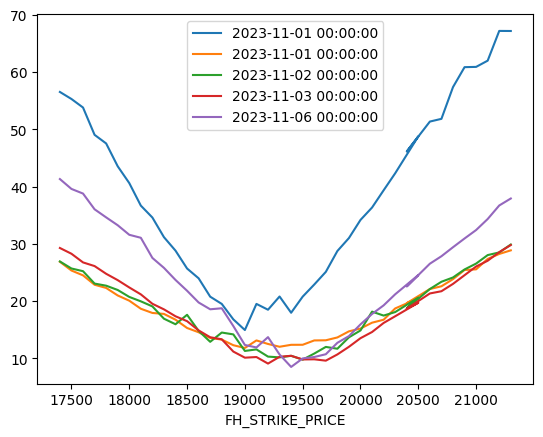

In [29]:
open_close_iv['Open'].iloc[-40:-35].T.plot()


In [32]:
open_close_iv['Open']

FH_STRIKE_PRICE,4300.0,4400.0,4500.0,4600.0,4700.0,4800.0,4900.0,5000.0,5100.0,5200.0,...,20900.0,21000.0,21100.0,21200.0,21300.0,21400.0,21500.0,21600.0,21700.0,22000.0
2010-01-04,38.304567,35.869057,33.3325,32.755557,29.602721,29.070435,26.623288,25.252243,24.756885,22.591061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,38.265928,36.965664,33.643098,31.635325,28.682783,28.45601,27.121759,26.297947,24.335907,23.722167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,36.677312,34.240233,32.475308,30.067487,29.081369,26.815018,25.281501,24.168471,23.159975,21.848216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,37.126917,34.748601,32.882697,30.989788,28.982443,27.581577,26.436718,25.19655,23.905014,22.467471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,36.17713,34.205936,32.317268,29.779635,28.813545,26.944539,26.852024,24.826777,24.101947,22.852835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.332754,13.968412,14.542704,15.361893,16.144999,16.857533,17.385866,18.107833,18.706936,NaN
2023-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.432333,15.14038,15.597952,16.824328,16.550098,18.046669,18.600229,19.372481,20.057203,NaN
2023-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.586835,14.222926,14.4289,15.886109,16.361716,0.0,17.785363,16.877713,19.451866,NaN
2023-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.212417,15.104592,15.60716,16.51006,17.291688,18.019659,18.861998,19.427134,20.056547,NaN


In [ ]:
otm_itm_df = pd.DataFrame(0,columns=['OTM_0.5%_CE','OTM_1%_CE','OTM_1.5%_CE','OTM_0.5%_PE','OTM_1%_PE','OTM_1.5%_PE'],index=nifty.index)

#iv_df = otm_itm_df.copy()

for c in tqdm(otm_itm_df.columns[:]):
    for e in monthly_expiries:
        df = options_data.loc[e]
        df = df[~df.index.duplicated()]

        prices,iv = getData(c, df, e)
        otm_itm_df[c] += prices.reindex(otm_itm_df.index).fillna(0)
        #iv_df[c] += iv.reindex(otm_itm_df.index).fillna(0)

In [87]:
otm_itm_df = otm_itm_df.replace(0,np.nan).dropna(axis=0,how='all')
#iv_df = iv_df.replace(0,np.nan).dropna(axis=0,how='all')

In [ ]:
#iv_df.iloc[:,:].loc['2023-06':].plot()

In [ ]:
prev day close iv
today open iv
small gap down
otm call iv drop

In [ ]:
options_data.loc['2010-01-28',4300,'PE']

In [425]:
trades

FH_TIMESTAMP  FH_EXPIRY_DT  FH_STRIKE_PRICE  FH_OPTION_TYPE  Direction
2010-04-21    2010-05-27    4800.0           CE              -1              7.00
2010-11-09    2010-11-25    5300.0           PE               1              0.15
2011-02-14    2011-02-24    4700.0           CE              -1           -675.95
2011-02-17    2011-02-24    6200.0           CE               1              0.05
2011-11-23    2011-11-24    4700.0           CE              -1             43.60
2012-08-13    2012-09-27    4700.0           PE              -1              0.75
2014-04-03    2014-05-29    6600.0           PE               1              7.65
2016-11-28    2017-01-25    7700.0           PE               1            -11.25
2017-02-28    2017-04-27    7900.0           CE              -1           -855.80
2017-03-28    2017-03-30    8700.0           PE              -1             -0.35
2017-11-28    2017-12-28    9900.0           CE               1            -28.90
2018-09-06    2018-09-27   

In [422]:
# BACKTESTER
pos_data = options_data.copy()
directions = np.random.randint(0,2,len(pos_data))
directions[directions == 0] = -1
pos_data = pos_data.assign(Direction=directions).set_index('Direction', append=True)
rets = (pos_data['FH_CLOSING_PRICE'] - pos_data['FH_OPENING_PRICE']).multiply(directions).replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()
trades = rets.reorder_levels([3,0,1,2,4]).sample(50).sort_index(level=0)

# TOTAL COSTS
trades.reorder_levels([1,2,3,4,0]).index


MultiIndex([('2010-05-27',  4800.0, 'CE', -1, '2010-04-21'),
            ('2010-11-25',  5300.0, 'PE',  1, '2010-11-09'),
            ('2011-02-24',  4700.0, 'CE', -1, '2011-02-14'),
            ('2011-02-24',  6200.0, 'CE',  1, '2011-02-17'),
            ('2011-11-24',  4700.0, 'CE', -1, '2011-11-23'),
            ('2012-09-27',  4700.0, 'PE', -1, '2012-08-13'),
            ('2014-05-29',  6600.0, 'PE',  1, '2014-04-03'),
            ('2017-01-25',  7700.0, 'PE',  1, '2016-11-28'),
            ('2017-04-27',  7900.0, 'CE', -1, '2017-02-28'),
            ('2017-03-30',  8700.0, 'PE', -1, '2017-03-28'),
            ('2017-12-28',  9900.0, 'CE',  1, '2017-11-28'),
            ('2018-09-27', 10800.0, 'PE', -1, '2018-09-06'),
            ('2019-06-13', 12500.0, 'CE', -1, '2019-06-07'),
            ('2019-06-27', 12000.0, 'CE',  1, '2019-06-14'),
            ('2019-09-26', 10700.0, 'CE',  1, '2019-09-17'),
            ('2019-10-03', 10700.0, 'PE',  1, '2019-09-18'),
            ('2020-01-09

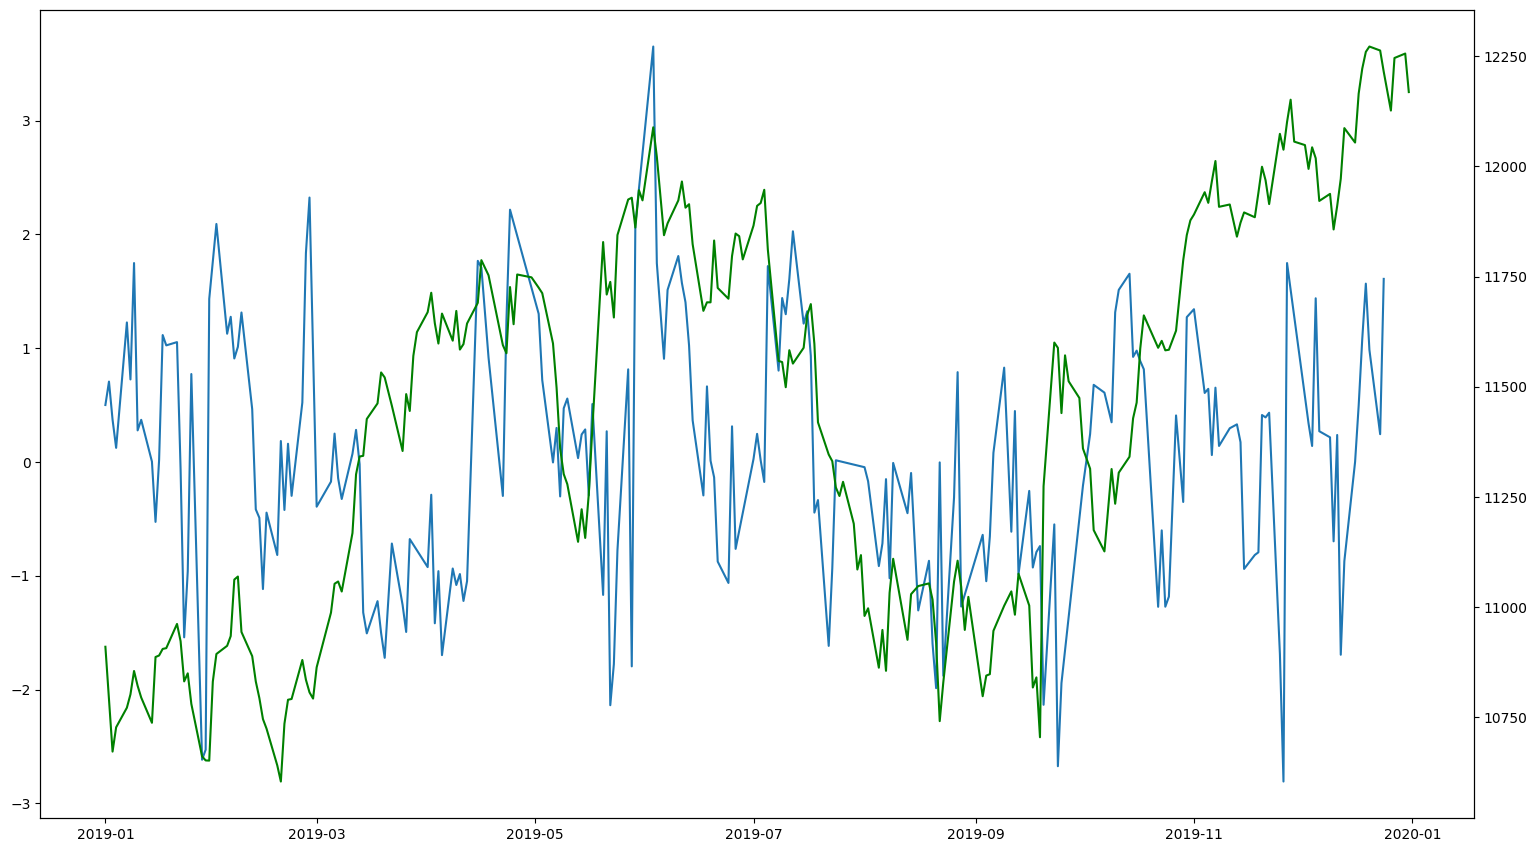

In [45]:
fig, ax_left = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax_right = ax_left.twinx()
zscore_iv = zscore(iv_df['OTM_1%_PE']/iv_df['OTM_1%_CE'],20)
ax_left.plot(zscore_iv.loc['2019'])
ax_right.plot(nifty.loc['2019','CLOSE'],color='g')

In [ ]:
iterate days

# getContracts(day)

# getTargetSL(strategy,strikes)

# 2023-12-28, 20,000 CE
